# GHG HLM on Scope 3 source Other Downstream

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import zscore
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
import warnings
from statsmodels.regression.mixed_linear_model import MixedLM


#read in dataset from GHG_post_outliers data set
other_downstream=pd.read_csv('/Users/amberjensen/Desktop/GHG_Emissions_Project/other_downstream.csv')

In [2]:
#check for info
other_downstream.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                141 non-null    object 
 1   account_id                  141 non-null    int64  
 2   Year                        141 non-null    int64  
 3   incorporated_country        141 non-null    object 
 4   Primary activity            141 non-null    object 
 5   Primary sector              141 non-null    object 
 6   Market_Cap_USD              112 non-null    float64
 7   Third_party_verification    141 non-null    object 
 8   Revenue_USD                 119 non-null    float64
 9   ebitda_USD                  119 non-null    float64
 10  grossProfit_USD             119 non-null    float64
 11  netIncome_USD               119 non-null    float64
 12  cashAndCashEquivalents_USD  119 non-null    float64
 13  shortTermInvestments_USD    119 non

In [3]:
#show a df for other_downstream
other_downstream.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,Aviva plc,1268,2018,United Kingdom,Insurance,Financial services,1.880010e+10,Third-party verification or assurance process ...,2.828417e+10,256540000.0,...,7.073011e+10,5.454917e+11,1.164463e+10,8.914511e+10,1.360678e+10,2.343785e+10,Other (downstream),252.0,61086.5000,4072324
1,British Land Company,2297,2018,United Kingdom,REIT,Financial services,6.501391e+09,Third-party verification or assurance process ...,1.148080e+09,-302260000.0,...,3.597910e+09,1.556512e+10,4.530090e+09,3.402330e+09,3.966210e+09,1.103503e+10,Other (downstream),2914903.0,14261.0000,4072324
2,J MURPHY & SONS LTD,9625,2018,United Kingdom,Transportation infrastructure & other construc...,Construction,NaN,Third-party verification or assurance process ...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Other (downstream),41.0,28042.6425,4072324
3,N Brown Group Plc,21811,2018,United Kingdom,Apparel stores,Discretionary retail,3.359579e+08,No third-party verification or assurance,1.161288e+09,153543000.0,...,0.000000e+00,1.284986e+09,8.895080e+08,0.000000e+00,6.497320e+08,3.954780e+08,Other (downstream),29.0,4159.1700,4072324
4,Petra Diamonds Pty Ltd,44407,2018,United Kingdom,Other non-metallic minerals,Other mineral mining,3.260332e+08,Third-party verification or assurance process ...,4.636000e+08,153900000.0,...,0.000000e+00,1.294800e+09,9.687000e+08,0.000000e+00,7.711000e+08,3.261000e+08,Other (downstream),712.0,196661.7400,4072324


In [4]:
#define a list of numeric columns
numeric_cols = ['Market_Cap_USD', 'Revenue_USD', 'ebitda_USD',
       'grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD',
       'shortTermInvestments_USD', 'longTermInvestments_USD',
       'totalAssets_USD', 'totalLiabilities_USD', 'totalInvestments_USD',
       'totalDebt_USD', 'totalEquity_USD', 'Scope_3_emissions_amount', 'scope_1_2_emissions_amount']

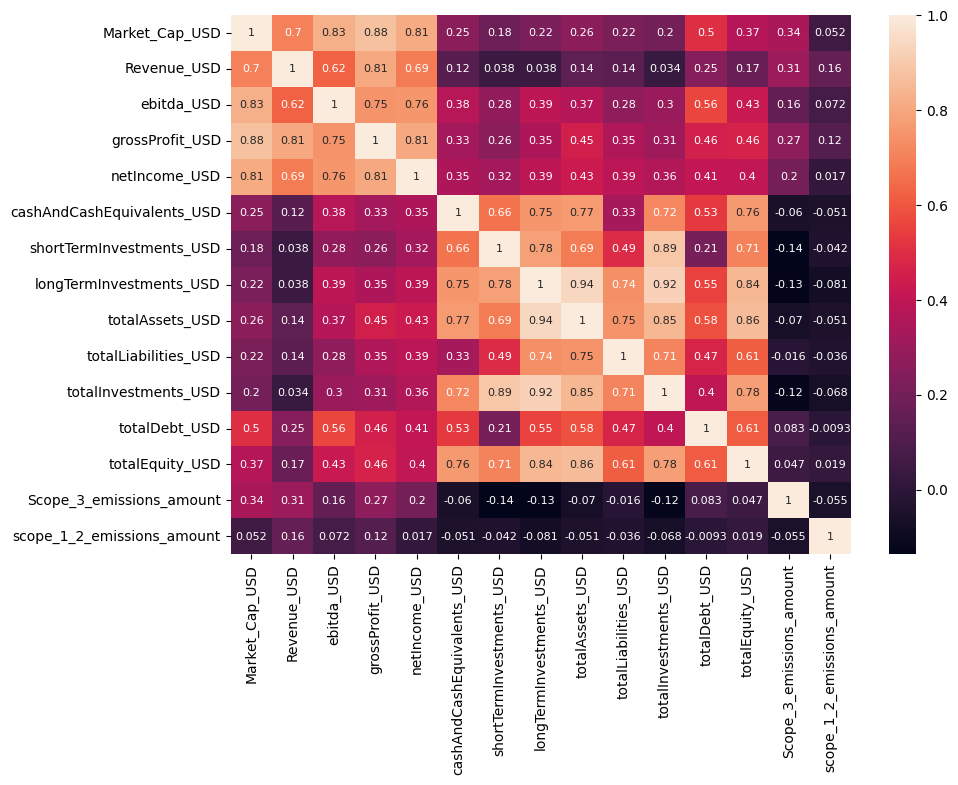

In [5]:
#plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(other_downstream[numeric_cols].corr(), annot=True, annot_kws={"size": 8})
plt.show()

In [6]:
#correlation matrix
other_downstream[numeric_cols].corr()

,Market_Cap_USD,Revenue_USD,ebitda_USD,grossProfit_USD,netIncome_USD,cashAndCashEquivalents_USD,shortTermInvestments_USD,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_amount,scope_1_2_emissions_amount
Market_Cap_USD,1.000000,0.701006,0.825268,0.875536,0.809136,0.254755,0.176770,0.218616,0.261961,0.222875,0.198829,0.498553,0.372873,0.339251,0.052065
Revenue_USD,0.701006,1.000000,0.623984,0.806274,0.686893,0.121836,0.037959,0.038213,0.138911,0.135704,0.033869,0.249311,0.172080,0.305358,0.158595
ebitda_USD,0.825268,0.623984,1.000000,0.750759,0.755844,0.378311,0.278597,0.393299,0.372521,0.275675,0.302820,0.564516,0.425450,0.155678,0.071605
grossProfit_USD,0.875536,0.806274,0.750759,1.000000,0.805493,0.327435,0.260417,0.348326,0.452704,0.353878,0.311592,0.455699,0.464231,0.269780,0.116305
netIncome_USD,0.809136,0.686893,0.755844,0.805493,1.000000,0.347597,0.324850,0.394064,0.428194,0.388441,0.363950,0.407720,0.401012,0.201130,0.017167
cashAndCashEquivalents_USD,0.254755,0.121836,0.378311,0.327435,0.347597,1.000000,0.663997,0.751422,0.769037,0.331872,0.719317,0.530993,0.762525,-0.060168,-0.050608
shortTermInvestments_USD,0.176770,0.037959,0.278597,0.260417,0.324850,0.663997,1.000000,0.780280,0.686359,0.491461,0.892499,0.209214,0.705067,-0.136370,-0.042422
longTermInvestments_USD,0.218616,0.038213,0.393299,0.348326,0.394064,0.751422,0.780280,1.000000,0.940934,0.737132,0.920423,0.552960,0.844907,-0.128650,-0.081103
totalAssets_USD,0.261961,0.138911,0.372521,0.452704,0.428194,0.769037,0.686359,0.940934,1.000000,0.750877,0.848837,0.583798,0.858677,-0.069755,-0.051270
totalLiabilities_USD,0.222875,0.135704,0.275675,0.353878,0.388441,0.331872,0.491461,0.737132,0.750877,1.000000,0.708891,0.468425,0.614162,-0.015962,-0.036256


In [7]:
#drop columns due to collinearity, keeping total
other_downstream=other_downstream.drop(columns=['ebitda_USD', 'grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD', 'shortTermInvestments_USD',
                                                'longTermInvestments_USD', 'totalEquity_USD', 
                                                "account_name", "Third_party_verification", "Scope_3_emissions_type"])

In [8]:
other_downstream.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_id                  141 non-null    int64  
 1   Year                        141 non-null    int64  
 2   incorporated_country        141 non-null    object 
 3   Primary activity            141 non-null    object 
 4   Primary sector              141 non-null    object 
 5   Market_Cap_USD              112 non-null    float64
 6   Revenue_USD                 119 non-null    float64
 7   totalAssets_USD             119 non-null    float64
 8   totalLiabilities_USD        119 non-null    float64
 9   totalInvestments_USD        119 non-null    float64
 10  totalDebt_USD               119 non-null    float64
 11  Scope_3_emissions_amount    141 non-null    float64
 12  scope_1_2_emissions_amount  141 non-null    float64
 13  Year_sq                     141 non

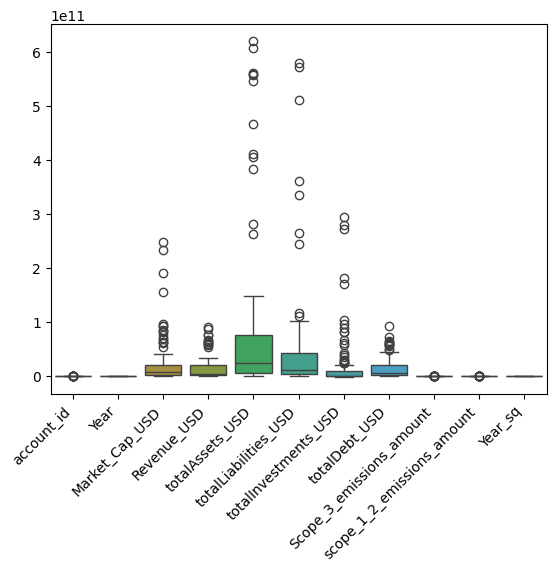

In [9]:
sns.boxplot(other_downstream)
plt.xticks(rotation=45, ha='right')
plt.show()

In [10]:
# copy dataframe
other_downstream_no_transform = other_downstream.copy()
# Change 'incorporated_country' to 'Countries' in other_downstream dataframe
other_downstream_no_transform = other_downstream_no_transform.rename(columns={'incorporated_country': 'Countries',
                                                       'Primary activity': 'Primary_activity',
                                                        'Primary sector': 'Primary_sector'})

print(other_downstream_no_transform.info())
other_downstream_no_transform.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_id                  141 non-null    int64  
 1   Year                        141 non-null    int64  
 2   Countries                   141 non-null    object 
 3   Primary_activity            141 non-null    object 
 4   Primary_sector              141 non-null    object 
 5   Market_Cap_USD              112 non-null    float64
 6   Revenue_USD                 119 non-null    float64
 7   totalAssets_USD             119 non-null    float64
 8   totalLiabilities_USD        119 non-null    float64
 9   totalInvestments_USD        119 non-null    float64
 10  totalDebt_USD               119 non-null    float64
 11  Scope_3_emissions_amount    141 non-null    float64
 12  scope_1_2_emissions_amount  141 non-null    float64
 13  Year_sq                     141 non

,account_id,Year,Countries,Primary_activity,Primary_sector,Market_Cap_USD,Revenue_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,1268,2018,United Kingdom,Insurance,Financial services,1.880010e+10,2.828417e+10,5.454917e+11,1.164463e+10,8.914511e+10,1.360678e+10,252.0,61086.5000,4072324
1,2297,2018,United Kingdom,REIT,Financial services,6.501391e+09,1.148080e+09,1.556512e+10,4.530090e+09,3.402330e+09,3.966210e+09,2914903.0,14261.0000,4072324
2,9625,2018,United Kingdom,Transportation infrastructure & other construc...,Construction,NaN,NaN,NaN,NaN,NaN,NaN,41.0,28042.6425,4072324
3,21811,2018,United Kingdom,Apparel stores,Discretionary retail,3.359579e+08,1.161288e+09,1.284986e+09,8.895080e+08,0.000000e+00,6.497320e+08,29.0,4159.1700,4072324
4,44407,2018,United Kingdom,Other non-metallic minerals,Other mineral mining,3.260332e+08,4.636000e+08,1.294800e+09,9.687000e+08,0.000000e+00,7.711000e+08,712.0,196661.7400,4072324


In [11]:
other_downstream_no_transform['Primary_sector'].value_counts()

Primary_sector
Financial services                         52
Electrical & electronic equipment          11
Construction                                9
Discretionary retail                        6
Transportation equipment                    6
Tobacco                                     6
Chemicals                                   5
Oil & gas retailing                         5
Light manufacturing                         5
Marine transport                            5
Food & beverage processing                  5
Convenience retail                          4
Land & property ownership & development     4
0                                           3
Air transport                               2
Other mineral mining                        2
Metal smelting, refining & forming          2
Bars, hotels & restaurants                  2
Thermal power generation                    1
Non-energy utilities                        1
Leisure & home manufacturing                1
Apparel design     

In [12]:
other_downstream_no_transform['Primary_activity'].value_counts().head(20)

Primary_activity
Banks                                                 32
REIT                                                  13
Transportation infrastructure & other construction     6
Tobacco products                                       6
Computer hardware                                      6
Automobiles                                            6
Insurance                                              5
Oil & gas marketing & retailing                        5
Marine freight                                         5
Other containers & packaging                           4
Real estate owners & developers                        4
Supermarkets, food & drugstores                        4
Other food processing                                  4
Specialty chemicals                                    4
Specialist retail                                      4
0                                                      3
Non-residential building construction                  3
Asset managers

In [13]:
# Looking at missing data
print(other_downstream_no_transform.isnull().mean().sort_values(ascending=False).round(3) * 100)

Market_Cap_USD                20.6
Revenue_USD                   15.6
totalAssets_USD               15.6
totalLiabilities_USD          15.6
totalInvestments_USD          15.6
totalDebt_USD                 15.6
account_id                     0.0
Year                           0.0
Countries                      0.0
Primary_activity               0.0
Primary_sector                 0.0
Scope_3_emissions_amount       0.0
scope_1_2_emissions_amount     0.0
Year_sq                        0.0
dtype: float64


Apply signed log transformation and split data by company and year into train_df (2018-2022) and test_df (2023):

In [14]:
numeric_cols = ['Market_Cap_USD', 'Revenue_USD', 'totalAssets_USD', 'totalInvestments_USD', 'totalLiabilities_USD', 'totalDebt_USD',
                'Scope_3_emissions_amount', 'scope_1_2_emissions_amount'
]
required_cols = [
    'account_id', 'Year', 'Year_sq', 'Countries', 'Primary_activity', 'Primary_sector'
] + numeric_cols

# --- Prepare Data ---
df = other_downstream_no_transform[required_cols].dropna()

# --- Signed log transform ---
def signed_log(x):
    return np.sign(x) * np.log(np.abs(x) + 1)

for col in numeric_cols:
    df[f'slog_{col}'] = signed_log(df[col])

# --- Company-level split by year ---
train_df = df[df['Year'].between(2018, 2022)].copy()
test_df  = df[df['Year'] == 2023].copy()

# Keep only companies present in training
valid_companies = set(train_df['account_id'].unique())
test_df = test_df[test_df['account_id'].isin(valid_companies)].copy()

# --- Remove rare categories in Primary_activity and Countries (≤2 rows) to prevent singular matrices ---
for col in ['Primary_activity', 'Countries']:
    value_counts = train_df[col].value_counts()
    allowed = value_counts[value_counts > 2].index
    train_df = train_df[train_df[col].isin(allowed)].copy()
    test_df = test_df[test_df[col].isin(allowed)].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (58, 22)
Test shape: (12, 22)


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, 6 to 112
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       58 non-null     int64  
 1   Year                             58 non-null     int64  
 2   Year_sq                          58 non-null     int64  
 3   Countries                        58 non-null     object 
 4   Primary_activity                 58 non-null     object 
 5   Primary_sector                   58 non-null     object 
 6   Market_Cap_USD                   58 non-null     float64
 7   Revenue_USD                      58 non-null     float64
 8   totalAssets_USD                  58 non-null     float64
 9   totalInvestments_USD             58 non-null     float64
 10  totalLiabilities_USD             58 non-null     float64
 11  totalDebt_USD                    58 non-null     float64
 12  Scope_3_emissions_amount    

In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 114 to 138
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       12 non-null     int64  
 1   Year                             12 non-null     int64  
 2   Year_sq                          12 non-null     int64  
 3   Countries                        12 non-null     object 
 4   Primary_activity                 12 non-null     object 
 5   Primary_sector                   12 non-null     object 
 6   Market_Cap_USD                   12 non-null     float64
 7   Revenue_USD                      12 non-null     float64
 8   totalAssets_USD                  12 non-null     float64
 9   totalInvestments_USD             12 non-null     float64
 10  totalLiabilities_USD             12 non-null     float64
 11  totalDebt_USD                    12 non-null     float64
 12  Scope_3_emissions_amount  

In [17]:
# Check number of 0's in train and test df's
print((train_df == 0).sum().sum())
print((test_df == 0).sum().sum())

0
0


## Other Downstream Null Mixed-Effects Model

Null mixed-effects model (random intercept only) to predict log-transformed Scope 3 emissions. The model serves as a baseline, capturing only the average emission level for each company, without incorporating any explanatory variables, and quantifies the improvement gained by including additional features and structure. The model is trained on 2018–2022 data and evaluated on a test set from 2023.

Model Structure:
- Random Effects:
    - Random intercept for each company ('account_id'), capturing baseline differences between companies
- Fixed Effects:
    - Intercept only (no predictors)

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Scope_3_emissions_amount
No. Observations: 58      Method:             REML                        
No. Groups:       19      Scale:              0.7058                      
Min. group size:  1       Log-Likelihood:     -108.6009                   
Max. group size:  5       Converged:          Yes                         
Mean group size:  3.1                                                     
------------------------------------------------------------------------------
                Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
------------------------------------------------------------------------------
Intercept        9.591        0.873     10.989     0.000      7.880     11.301
Group Var       14.137        6.912                                           

R²(log):    -0.01%
R²(orig):   -28.07%
MAPE:       8424.58%
MAPE(log):  52.22%
MAE(log):   3.41
RM

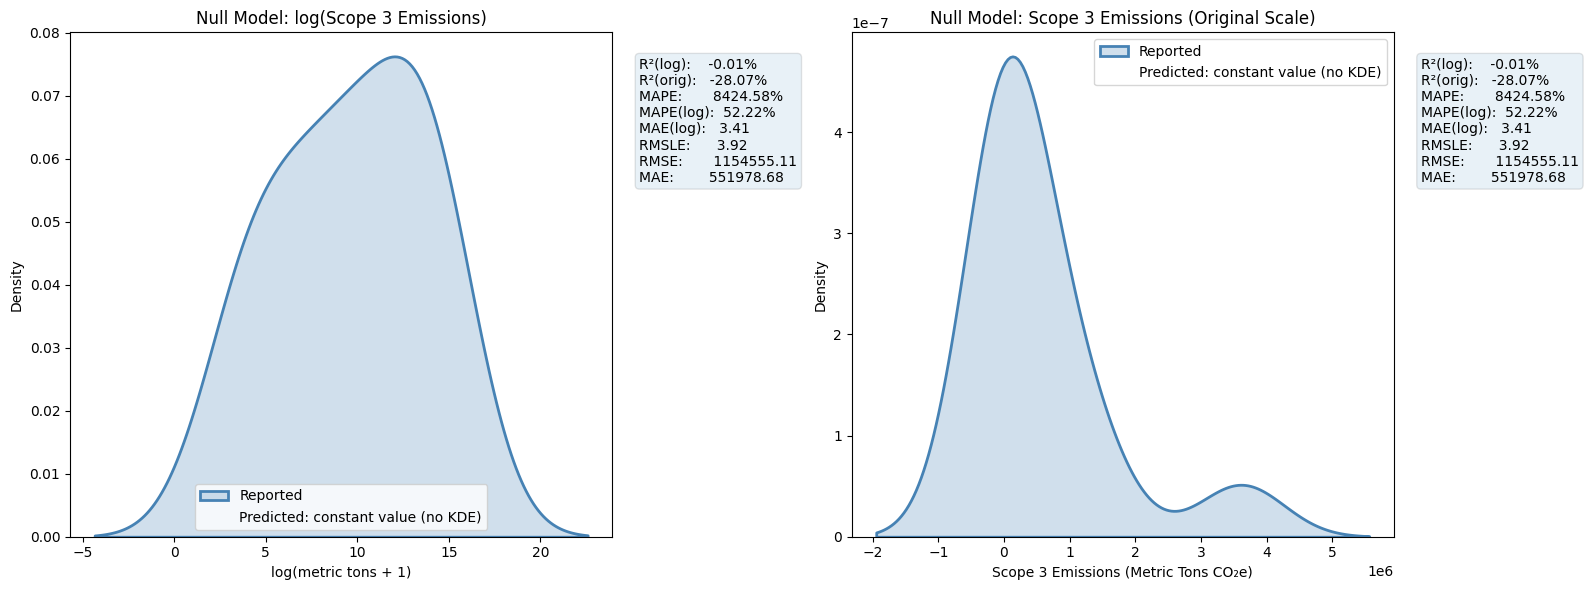

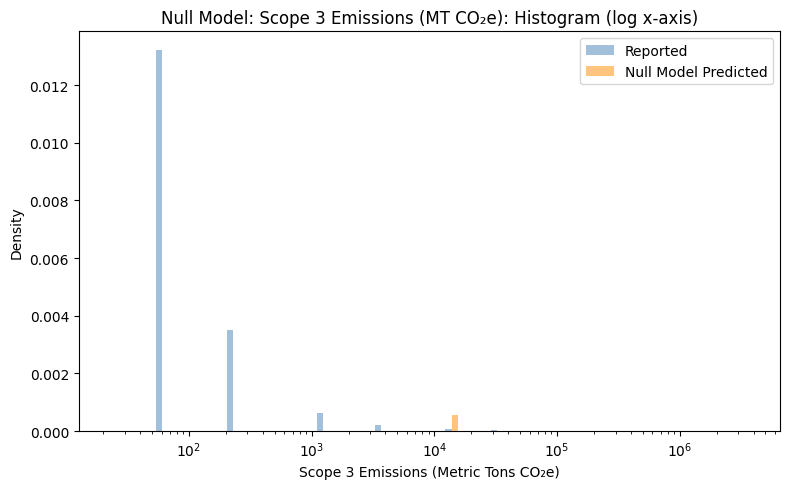

In [18]:
# --- Ensure log_Scope_3_emissions_amount exists (if not, create it) ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- FIT THE NULL MODEL (random intercept only) ---
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    null_model = smf.mixedlm(
        "log_Scope_3_emissions_amount ~ 1",
        train_df,
        groups=train_df["account_id"]
    )
    null_result = null_model.fit(method="lbfgs")

if not null_result.converged:
    print("WARNING: Null model did not fully converge.")

print(null_result.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_null'] = null_result.predict(test_df)

# --- METRICS ---
y_true_log = test_df['log_Scope_3_emissions_amount']
y_pred_log = test_df['predicted_null']

# Remove inf/nan for robust metrics
mask = np.isfinite(y_true_log) & np.isfinite(y_pred_log)
y_true_log = y_true_log[mask]
y_pred_log = y_pred_log[mask]
test_df = test_df.loc[mask].copy()

# Log-scale MAPE
mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100

# Back-transform for original scale metrics
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_null'])
y_true = test_df['Reported_Scope_3']
y_pred = test_df['Predicted_Scope_3']

# Remove inf/nan for robust metrics
mask2 = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask2]
y_pred = y_pred[mask2]

# Metrics calculations
r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_orig_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)
mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

# Print metrics text
metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_orig_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Density plot on log scale
if y_pred_log.nunique() > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Null Model Predicted', linewidth=2, fill=True, ax=axes[0], color='gray')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Null Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()

axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

# 2. Density plot on original scale
if y_pred.nunique() > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Null Model Predicted', linewidth=2, fill=True, ax=axes[1], color='gray')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Null Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()

axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Histogram on original scale with log x-axis
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

plt.figure(figsize=(8, 5))
sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Null Model Predicted")
plt.xscale("log")
plt.title("Null Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --- RETURN METRICS FOR SUMMARY TABLE ---
null_model_metrics = {
    "Model": "Null (RI)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_orig_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,  # <--- include MAE for log-transformed emissions
    "Notes": "Random intercept only"
}

## Other Downstream Two-Level Mixed-Effects Model

Two-level hierarchical linear mixed-effects model to predict log-transformed Scope 3 emissions at the company level. The model is fit to training data (from 2018–2022), and predictions are evaluated on a test set (from 2023).  This model provides a baseline for including time trends and company-level variability.
 
Model Structure:
- Random Effects:
    - Random intercept for each company ('account_id'), capturing baseline differences between companies.<br>
- Fixed Effects:
    - Year (numeric)
    - Year squared ('Year_sq', quadratic time trend)

Two-Level Model: Company/year group size summary:
count    19.000000
mean      3.052632
std       1.580214
min       1.000000
25%       1.500000
50%       3.000000
75%       4.500000
max       5.000000
dtype: float64
                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Scope_3_emissions_amount
No. Observations: 58      Method:             REML                        
No. Groups:       19      Scale:              0.7082                      
Min. group size:  1       Log-Likelihood:     -110.9827                   
Max. group size:  5       Converged:          Yes                         
Mean group size:  3.1                                                     
---------------------------------------------------------------------------
                Coef.     Std.Err.     z     P>|z|     [0.025      0.975]  
---------------------------------------------------------------------------
Intercept     56925.432  287940.767   0.198  0.84

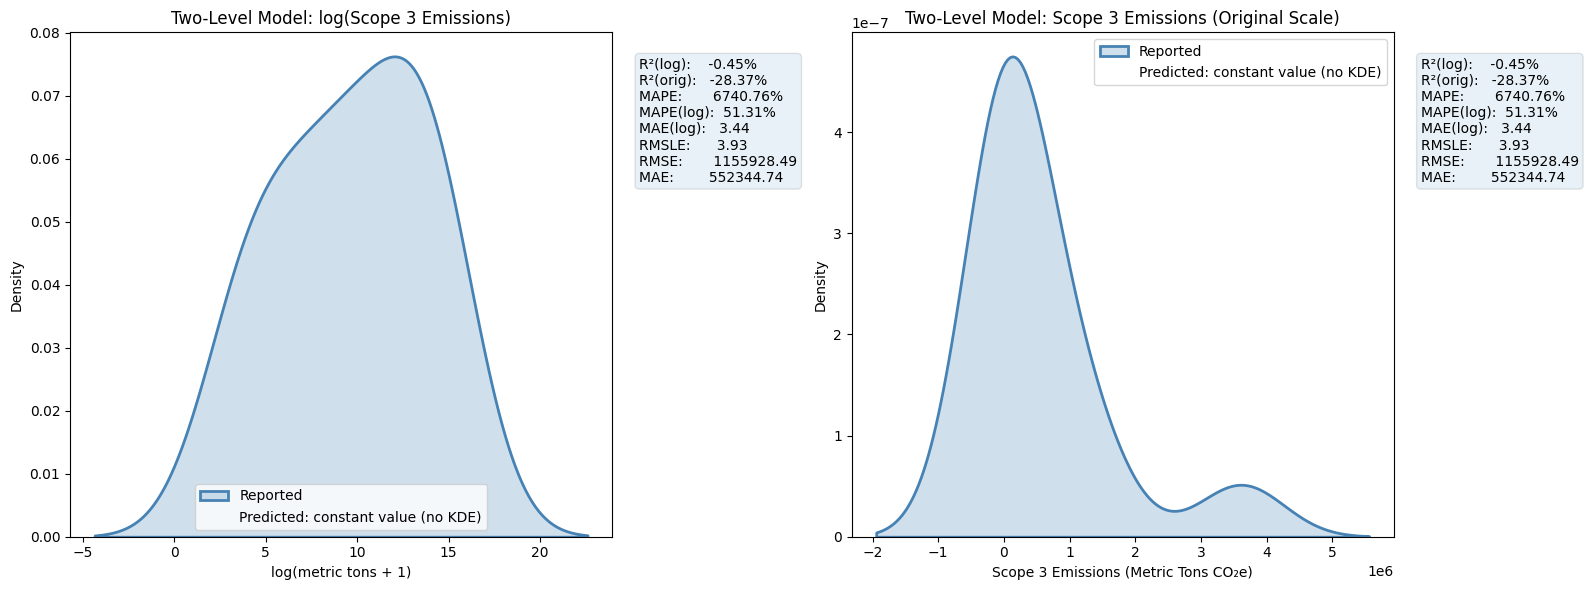

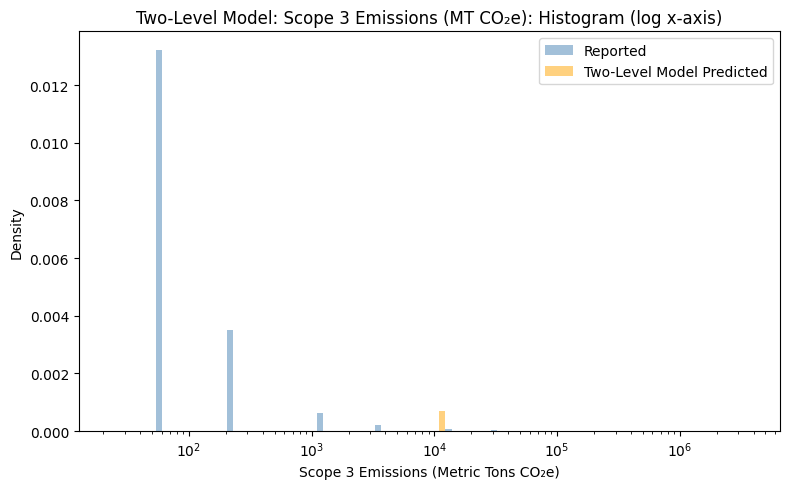

In [19]:
# --- Ensure log_Scope_3_emissions_amount exists (if not, create it) ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- Check group sizes ---
group_sizes = train_df.groupby('account_id').size()
print("Two-Level Model: Company/year group size summary:")
print(group_sizes.describe())

# --- FIT THE TWO-LEVEL MODEL (random intercept, +Year, +Year_sq) ---
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    model = smf.mixedlm(
        "log_Scope_3_emissions_amount ~ Year + Year_sq",
        train_df,
        groups=train_df["account_id"],
        re_formula="1"
    )
    result_twolevel = model.fit(method="lbfgs")

if not result_twolevel.converged:
    print("WARNING: Two-level mixed model did not fully converge.")

print(result_twolevel.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_mixed'] = result_twolevel.predict(test_df)

# --- METRICS ---
y_true_log = test_df['log_Scope_3_emissions_amount']
y_pred_log = test_df['predicted_mixed']

# Remove inf/nan for robust metrics
mask = np.isfinite(y_true_log) & np.isfinite(y_pred_log)
y_true_log = y_true_log[mask]
y_pred_log = y_pred_log[mask]
test_df = test_df.loc[mask].copy()

# Log-scale MAPE
mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100

# Back-transform for original scale metrics
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_mixed'])
y_true = test_df['Reported_Scope_3']
y_pred = test_df['Predicted_Scope_3']

# Remove inf/nan for robust metrics
mask2 = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask2]
y_pred = y_pred[mask2]

# Metrics calculations
r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_orig_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)
mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

# Print metrics
metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_orig_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Density plot on log scale
if y_pred_log.nunique() > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Two-Level Model Predicted', linewidth=2, fill=True, ax=axes[0], color='orange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Two-Level Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()

axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

# 2. Density plot on original scale
if y_pred.nunique() > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Two-Level Model Predicted', linewidth=2, fill=True, ax=axes[1], color='orange')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Two-Level Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()

axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Histogram on original scale with log x-axis
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

plt.figure(figsize=(8, 5))
sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
sns.histplot(y_pred, bins=log_bins, stat="density", color="orange", alpha=0.5, label="Two-Level Model Predicted")
plt.xscale("log")
plt.title("Two-Level Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --- RETURN METRICS FOR SUMMARY TABLE ---
two_level_model_metrics = {
    "Model": "2-level (RI+S)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_orig_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,  # <--- include MAE for log-transformed emissions
    "Notes": "+Year, Year_sq"
}

## Other Downstream Three-Level Mixed-Effects Model

A three-level hierarchical linear mixed-effects model is used to predict log-transformed Scope 3 emissions. It takes into account differences between primary activity, differences between companies, and changes over time. The model is trained using data from 2018 to 2022, and then tested on new data from 2023. This model provides insight on how emissions are influenced by primary activity, by individual companies, by financial and emissions factors, and by trends over time.

Model Structure:

- Level 3 (Primary Activity):<br>
    - Random intercept and random slope for Year for each primary activity ('Primary_activity'), capturing baseline primary activity and primary activity-specific time trends.<br>
- Level 2 (Account/Company):
    - Random intercept for each company ('account_id'), capturing company-level deviations within each primary activity.
- Level 1 (Yearly Observations):
    - Repeated annual observations within each company.

- Fixed Effects:
    - Signed log-transformed market cap ('slog_Market_Cap_USD')
    - Signed log-transformed revenue ('slog_Revenue_USD')
    - *Removed: Signed log-transformed EBITDA ('slog_ebitda_USD') due to collinearity*
    - Signed log-transformed Scope 1 & 2 emissions ('slog_scope_1_2_emissions_amount')

                     Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   log_Scope_3_emissions_amount
No. Observations:   58        Method:               REML                        
No. Groups:         13        Scale:                0.6483                      
Min. group size:    1         Log-Likelihood:       -113.5239                   
Max. group size:    13        Converged:            Yes                         
Mean group size:    4.5                                                         
--------------------------------------------------------------------------------
                                     Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                            -6.998   10.494 -0.667 0.505 -27.565 13.569
slog_Market_Cap_USD                  -0.130    0.505 -0.257 0.797  -1.120  0.860
slog_Revenue_USD                      0.907    0.6

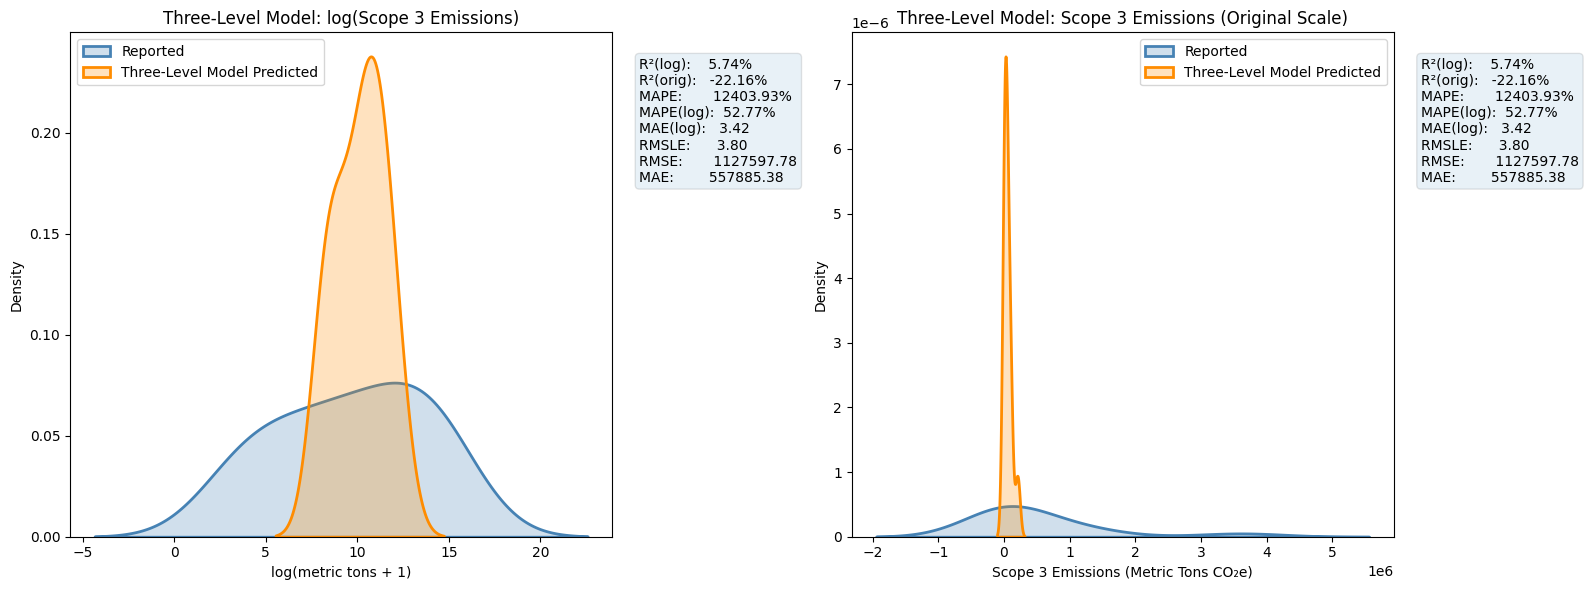

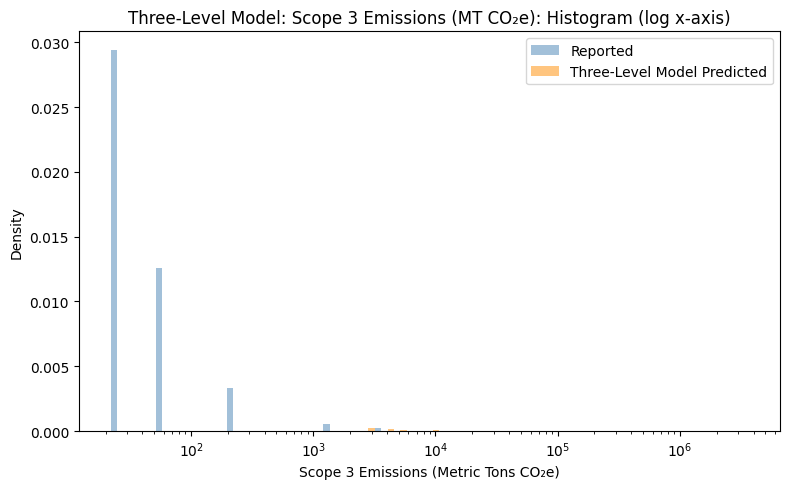

In [20]:
# --- Ensure grouping/categorical variables are string ---
for col in ['Countries', 'account_id', 'Primary_activity', 'Primary_sector']:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

# --- Center the Year variable ---
year_mean = train_df['Year'].mean()
train_df['Year_centered'] = train_df['Year'] - year_mean
test_df['Year_centered'] = test_df['Year'] - year_mean

# --- Ensure log-transformed target exists ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- FIT THE 3-LEVEL MIXED MODEL with Primary_activity as Level 3 group ---
vc = {'account_id': '0 + C(account_id)'}  # Level 2: account_id random intercept

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    model_3level = MixedLM.from_formula(
        'log_Scope_3_emissions_amount ~ slog_Market_Cap_USD + slog_Revenue_USD + slog_scope_1_2_emissions_amount',
        groups='Primary_activity',
        re_formula='~Year_centered',
        vc_formula=vc,
        data=train_df
    )
    result_3level = model_3level.fit(method="lbfgs", maxiter=1000)

if not result_3level.converged:
    print("WARNING: Three-level mixed model did not fully converge.")

print(result_3level.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_mixed'] = result_3level.predict(test_df)

# --- Compute back-transformed values ---
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_mixed'])

# --- Robust Mask for finite values everywhere ---
mask = (
    np.isfinite(test_df['log_Scope_3_emissions_amount']) &
    np.isfinite(test_df['predicted_mixed']) &
    np.isfinite(test_df['Reported_Scope_3']) &
    np.isfinite(test_df['Predicted_Scope_3'])
)
test_df = test_df.loc[mask].copy()

y_true_log = test_df['log_Scope_3_emissions_amount'].values
y_pred_log = test_df['predicted_mixed'].values
y_true = test_df['Reported_Scope_3'].values
y_pred = test_df['Predicted_Scope_3'].values

# Final defensive check and diagnostics
arrays = {
    "y_true_log": y_true_log,
    "y_pred_log": y_pred_log,
    "y_true": y_true,
    "y_pred": y_pred,
}
for arr_name, arr in arrays.items():
    if not np.all(np.isfinite(arr)):
        print(f"ERROR: {arr_name} contains non-finite values!")
        print(f"Non-finite indices: {np.where(~np.isfinite(arr))[0]}")
        print(f"Values: {arr[~np.isfinite(arr)]}")
        raise ValueError(f"{arr_name} contains infs or NaNs after masking!")

# --- METRICS ---
mae_log = mean_absolute_error(y_true_log, y_pred_log)
nonzero_mask = y_true_log != 0
if np.any(nonzero_mask):
    mape_log = np.mean(np.abs((y_true_log[nonzero_mask] - y_pred_log[nonzero_mask]) / y_true_log[nonzero_mask])) * 100
else:
    mape_log = np.nan

r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)

metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
if len(np.unique(y_pred_log)) > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Three-Level Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Three-Level Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

if len(np.unique(y_pred)) > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Three-Level Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Three-Level Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Filter strictly positive values for histogram (log x-axis requires >0)
y_true_pos = y_true[y_true > 0]
y_pred_pos = y_pred[y_pred > 0]

if y_true_pos.size > 0 and y_pred_pos.size > 0:
    min_val = min(y_true_pos.min(), y_pred_pos.min())
    max_val = max(y_true_pos.max(), y_pred_pos.max())
    if min_val == max_val:
        print("Skipping histogram: Only one unique positive value present.")
    else:
        log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)

        plt.figure(figsize=(8, 5))
        sns.histplot(y_true_pos, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
        sns.histplot(y_pred_pos, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Three-Level Model Predicted")
        plt.xscale("log")
        plt.title("Three-Level Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
        plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("Skipping histogram: Not enough positive values in y_true or y_pred for log-scale histogram.")

# --- RETURN METRICS FOR SUMMARY TABLE ---
three_level_model_metrics = {
    "Model": "3-level (Primary Activity/Account/Year)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,
    "MAPE(log)": mape_log,
}

## Other Downstream Full Mixed-Effects Model

A full mixed-effects model is used to predict company Scope 3 emissions, using financial and emissions data, along with information about country, industry, and year. The model is trained on data from 2018 to 2022, and tested on data from 2023. This full model helps provides insights into how a company’s finances, emissions, primary activity, country and the year influence emissions.<br>

Model Structure:<br>

- Random Effects:<br>
    - Random intercept for each company ('account_id'), capturing company-level baseline differences
- Fixed Effects:<br>
    - Signed log-transformed financial and emissions features:<br>
        - Revenue ('slog_Revenue_USD')<br>
        - Total Assets ('slog_totalAssets_USD')<br>
        - Scope 1&2 Emissions ('slog_scope_1_2_emissions_amount')<br>
    - Country ('Countries', as a categorical variable)<br>
    - Primary Activity ('Primary_activity', as a categorical variable)<br>
    - Year (numeric)<br>

                                              Mixed Linear Model Regression Results
Model:                              MixedLM                   Dependent Variable:                   slog_Scope_3_emissions_amount
No. Observations:                   58                        Method:                               ML                           
No. Groups:                         19                        Scale:                                0.7235                       
Min. group size:                    1                         Log-Likelihood:                       -88.5998                     
Max. group size:                    5                         Converged:                            Yes                          
Mean group size:                    3.1                                                                                          
---------------------------------------------------------------------------------------------------------------------------------
      

/Users/amberjensen/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2704: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


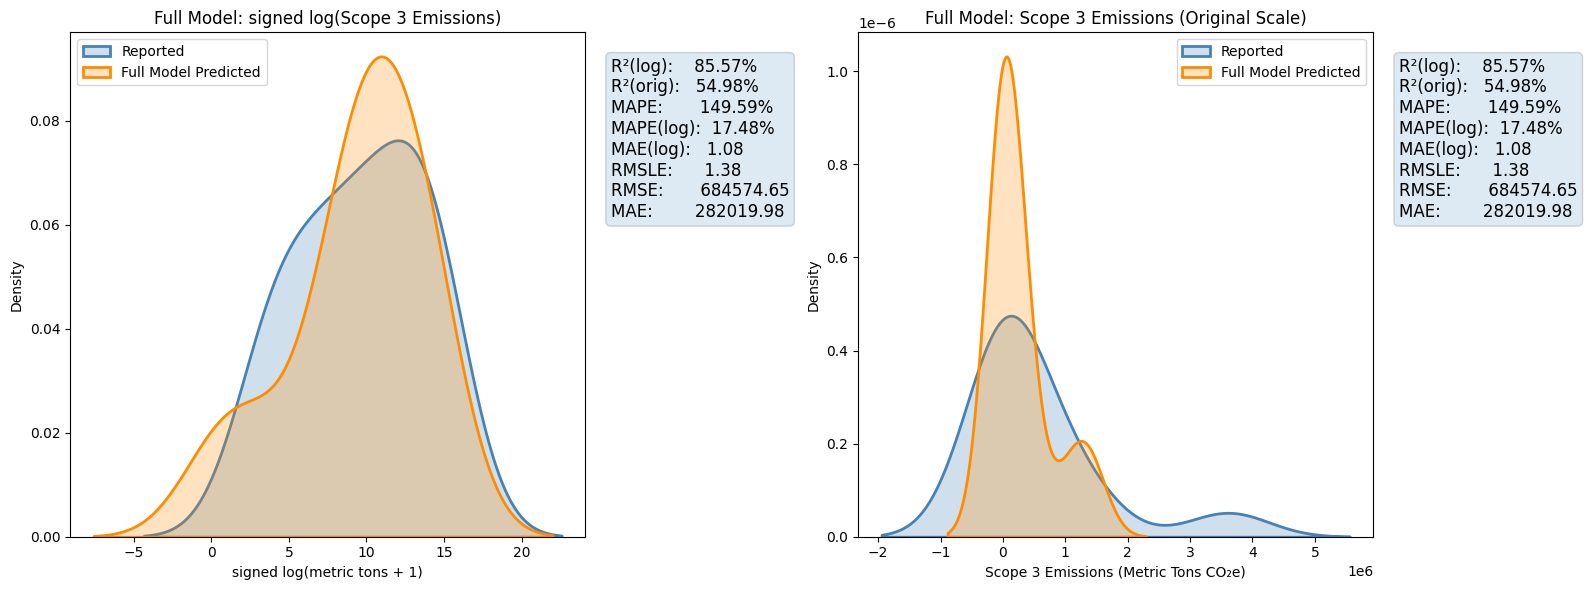

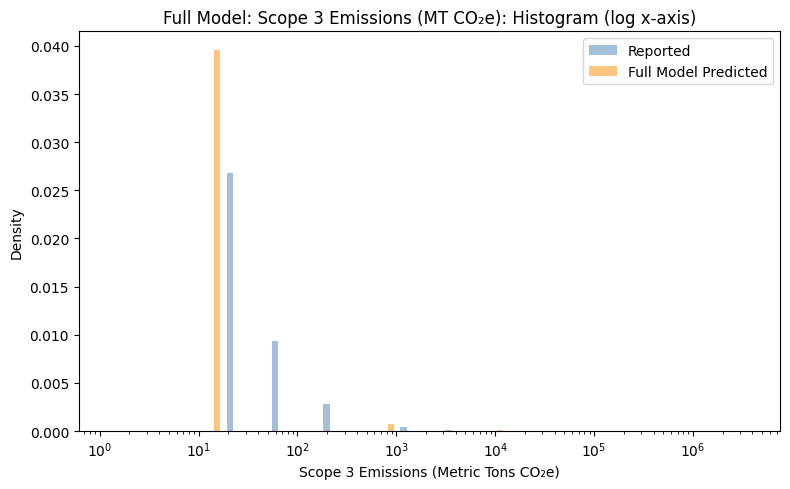

In [21]:
# --- Feature and target columns ---
numeric_cols = ['Revenue_USD',
 'totalAssets_USD',
 'Scope_3_emissions_amount',
 'scope_1_2_emissions_amount'
]
feature_cols_slog = [f'slog_{col}' for col in numeric_cols if col != 'Scope_3_emissions_amount']
target_col_slog = 'slog_Scope_3_emissions_amount'

# --- Filter for required columns only ---
required_cols = feature_cols_slog + [target_col_slog, 'Countries', 'Year', 'account_id', 'Primary_activity']
train_df_full = train_df.dropna(subset=required_cols).copy()
test_df_full = test_df.dropna(subset=required_cols).copy()

if test_df_full.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_slog) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_slog} ~ {fixed_effects}'

    # --- Fit the full mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_full, groups=train_df_full['account_id'])
        mdf = md.fit(reml=False)
    print(mdf.summary())

    # --- Predict on test set ---
    test_df_full['predicted_log'] = mdf.predict(test_df_full)
    test_df_full['predicted'] = np.sign(test_df_full['predicted_log']) * (np.expm1(np.abs(test_df_full['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_full[target_col_slog]
    y_pred_log = test_df_full['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_full['predicted']

    # Mask for finite values
    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Metrics calculations
    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

    metrics_text = (
        f"R²(log):    {r2_log_pct:.2f}%\n"
        f"R²(orig):   {r2_pct:.2f}%\n"
        f"MAPE:       {mape_orig:.2f}%\n"
        f"MAPE(log):  {mape_log:.2f}%\n"
        f"MAE(log):   {mae_log:.2f}\n"
        f"RMSLE:      {rmsle:.2f}\n"
        f"RMSE:       {rmse_orig:.2f}\n"
        f"MAE:        {mae_orig:.2f}"
    )

    print("\nFull Mixed-Effects Model (Full Model) Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf.params,
        'pvalue': mdf.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Density plot on log scale
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='Full Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Full Model: signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    # 2. Density plot on original scale
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='Full Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Full Model: Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    plt.tight_layout()
    plt.show()

    # Histogram on original scale with log x-axis
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Full Model Predicted")
    plt.xscale("log")
    plt.title("Full Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    full_model_metrics = {
        "Model": "Full Model",
        "R2_log": r2_log_pct / 100,
        "R2_orig": r2_pct / 100,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "MAE_log": mae_log
    }

## Other Downstream Optimized Mixed-Effects Model

An optimized mixed-effects model is used to predict company Scope 3 emissions. The model provides accurate prediction using only the most significant predictive features, while still accounting for primary activity, country and company level effects. The model is trained on data from 2018–2022 and evaluated on test data from 2023.

Model Structure:

- Random Effects:
    - Random intercept for each company ('account_id'), capturing company-level baseline differences
- Fixed Effects:
    - Signed log-transformed features:
        - Revenue ('slog_Revenue_USD') 
        - Total Assets ('slog_totalAssets_USD')
        - Scope 1 & 2 Emissions ('slog_scope_1_2_emissions_amount')
    - Country ('Countries', as a categorical variable)
    - Primary Activity ('Primary_activity', as a categorical variable)

                                            Mixed Linear Model Regression Results
Model:                              MixedLM                 Dependent Variable:                 slog_Scope_3_emissions_amount
No. Observations:                   58                      Method:                             ML                           
No. Groups:                         19                      Scale:                              0.7542                       
Min. group size:                    1                       Log-Likelihood:                     -88.7900                     
Max. group size:                    5                       Converged:                          Yes                          
Mean group size:                    3.1                                                                                      
-----------------------------------------------------------------------------------------------------------------------------
                                    

/Users/amberjensen/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2704: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


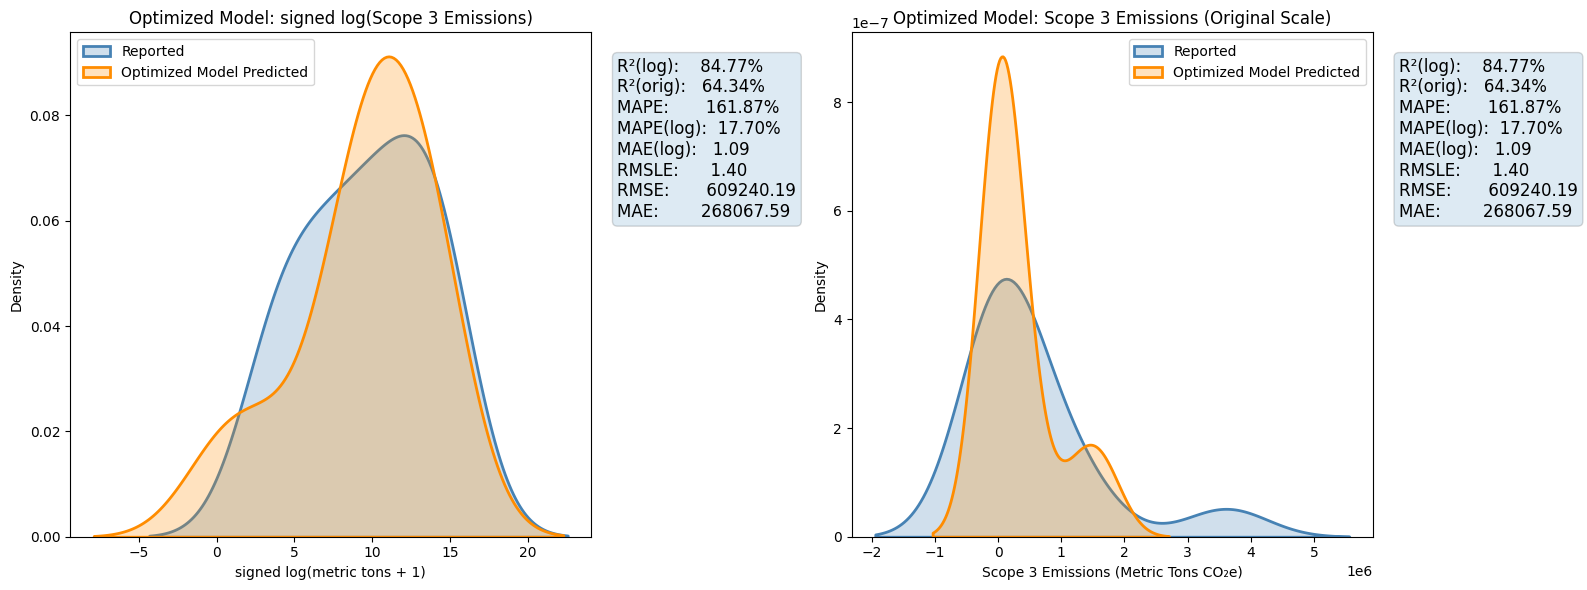

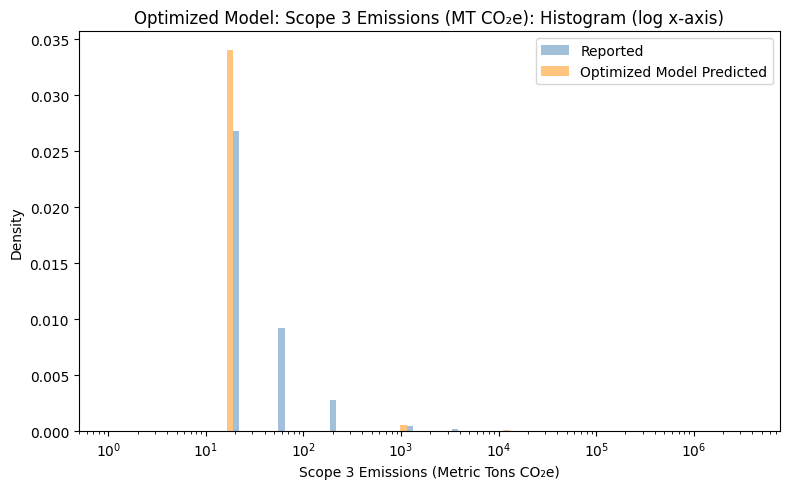

In [22]:
feature_cols_slog = [
    'slog_Revenue_USD',
    'slog_totalAssets_USD',
    'slog_scope_1_2_emissions_amount'
]
target_col_slog = 'slog_Scope_3_emissions_amount'

# --- Filter for required columns only ---
all_model_vars = feature_cols_slog + [target_col_slog, 'Countries', 'Year', 'account_id', 'Primary_activity']
train_df_opt = train_df.dropna(subset=all_model_vars).copy()
test_df_opt = test_df.dropna(subset=all_model_vars).copy()

if test_df_opt.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_slog) +
        ' + C(Countries) + C(Primary_activity)'
    )
    formula = f'{target_col_slog} ~ {fixed_effects}'

    # --- Fit the optimized mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_opt, groups=train_df_opt['account_id'])
        mdf_optimized = md.fit(reml=False)
    print(mdf_optimized.summary())

    # --- Predict on test set ---
    test_df_opt['predicted_log'] = mdf_optimized.predict(test_df_opt)
    test_df_opt['predicted'] = np.sign(test_df_opt['predicted_log']) * (np.expm1(np.abs(test_df_opt['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_opt[target_col_slog]
    y_pred_log = test_df_opt['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_opt['predicted']

    # Mask for valid/finites
    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Metrics calculations
    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <-- MAE for log-transformed emissions

    metrics_text = (
        f"R²(log):    {r2_log_pct:.2f}%\n"
        f"R²(orig):   {r2_pct:.2f}%\n"
        f"MAPE:       {mape_orig:.2f}%\n"
        f"MAPE(log):  {mape_log:.2f}%\n"
        f"MAE(log):   {mae_log:.2f}\n"
        f"RMSLE:      {rmsle:.2f}\n"
        f"RMSE:       {rmse_orig:.2f}\n"
        f"MAE:        {mae_orig:.2f}"
    )

    print("\nOptimized Mixed-Effects Model: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_optimized.params,
        'pvalue': mdf_optimized.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))

    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Density plot on log scale
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='Optimized Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Optimized Model: signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    # 2. Density plot on original scale
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='Optimized Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Optimized Model: Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    plt.tight_layout()
    plt.show()

    # Histogram on original scale with log x-axis
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Optimized Model Predicted")
    plt.xscale("log")
    plt.title("Optimized Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    optimized_model_metrics = {
        "Model": "Optimized",
        "R2_log": r2_log_pct / 100,
        "R2_orig": r2_pct / 100,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "MAE_log": mae_log
    }

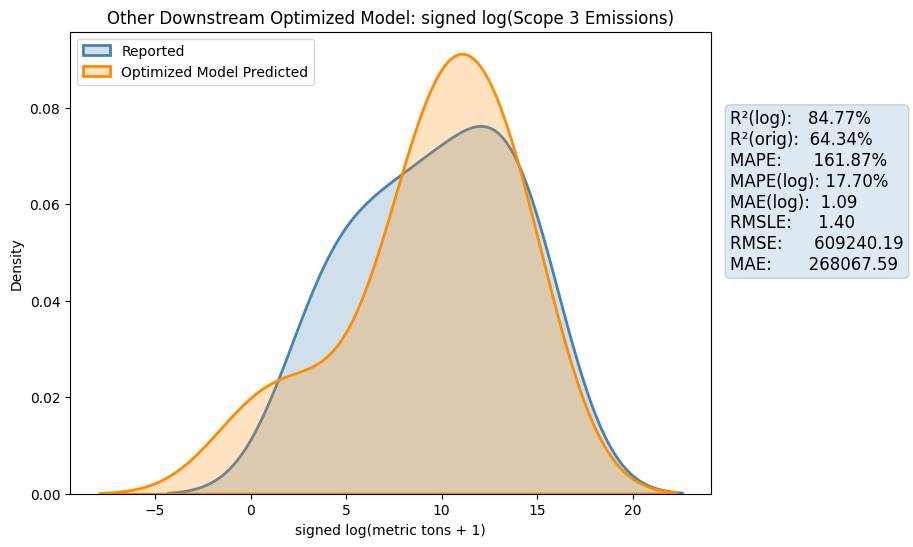

In [23]:
metrics_text_log = (
    f"R²(log):   {r2_log_pct:.2f}%\n"
    f"R²(orig):  {r2_pct:.2f}%\n"
    f"MAPE:      {mape_orig:.2f}%\n"
    f"MAPE(log): {mape_log:.2f}%\n"
    f"MAE(log):  {mae_log:.2f}\n"
    f"RMSLE:     {rmsle:.2f}\n"
    f"RMSE:      {rmse_orig:.2f}\n"
    f"MAE:       {mae_orig:.2f}"
)

fig, ax = plt.subplots(figsize=(9.5, 6))  # Wider to make room for the box

if hasattr(y_pred_log, "nunique"):
    multiple_vals = y_pred_log.nunique() > 1
else:
    multiple_vals = len(set(y_pred_log)) > 1

if multiple_vals:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=ax, color='steelblue')
    sns.kdeplot(y_pred_log, label='Optimized Model Predicted', linewidth=2, fill=True, ax=ax, color='darkorange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=ax, color='steelblue')
    ax.plot([], [], ' ', label="Predicted: constant value (no KDE)")

ax.set_title("Other Downstream Optimized Model: signed log(Scope 3 Emissions)")
ax.set_xlabel("signed log(metric tons + 1)")
ax.set_ylabel("Density")
ax.legend()

# Place metrics box outside plot to the right
fig.text(
    0.82, 0.75, metrics_text_log,
    va='top', ha='left',
    fontsize=12, bbox=dict(boxstyle='round', alpha=0.15)
)

plt.subplots_adjust(right=0.8)  # Make sure there's room for the box
fig.savefig("other_downstream_scope3_log_density.png", dpi=300, bbox_inches='tight')
plt.show()

# Metrics Table for Other Downstream

In [24]:
metrics_dicts = [
    null_model_metrics,
    two_level_model_metrics,
    three_level_model_metrics,
    full_model_metrics,
    optimized_model_metrics
]

for metrics, train, test in zip(
        metrics_dicts,
        [train_df, train_df, train_df, train_df, train_df],
        [test_df, test_df, test_df, test_df, test_df]):
    
    metrics["# Obs (train)"] = len(train)
    metrics["# Obs (test)"] = len(test)
    metrics["# Obs (train/test)"] = f"{len(train)}/{len(test)}"

metrics_df = pd.DataFrame(metrics_dicts)

# Ensure all relevant columns are ordered and present
desired_order = [
    "Model", "R2_log", "R2_orig", "RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "# Obs (train/test)"
]


# Ensure MAE_log is present, fill with NaN if missing
if "MAE_log" not in metrics_df.columns:
    metrics_df["MAE_log"] = np.nan

metrics_df = metrics_df[[col for col in desired_order if col in metrics_df.columns]]

metrics_df_display = metrics_df.copy()
if "R2_log" in metrics_df_display.columns:
    metrics_df_display["R2_log"] = (metrics_df_display["R2_log"] * 100).map("{:.2f}%".format)
if "R2_orig" in metrics_df_display.columns:
    metrics_df_display["R2_orig"] = (metrics_df_display["R2_orig"] * 100).map("{:.2f}%".format)
for col in ["RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "MAPE(log)"]:
    if col in metrics_df_display.columns:
        metrics_df_display[col] = metrics_df_display[col].map("{:.2f}".format)

from IPython.display import display
display(metrics_df_display)

,Model,R2_log,R2_orig,RMSE,MAE,MAE_log,RMSLE,MAPE,# Obs (train/test)
0,Null (RI),-0.01%,-28.07%,1154555.11,551978.68,3.41,3.92,8424.58,58/12
1,2-level (RI+S),-0.45%,-28.37%,1155928.49,552344.74,3.44,3.93,6740.76,58/12
2,3-level (Primary Activity/Account/Year),5.74%,-22.16%,1127597.78,557885.38,3.42,3.80,12403.93,58/12
3,Full Model,85.57%,54.98%,684574.65,282019.98,1.08,1.38,149.59,58/12
4,Optimized,84.77%,64.34%,609240.19,268067.59,1.09,1.40,161.87,58/12
